In [1]:
%load_ext autoreload
%autoreload 2

In [89]:
%matplotlib inline

import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

import torch
from torch.utils.data import DataLoader
from torch import optim

from utils import log_textfile, load_model
from basetrainer import BaseTrainer
from dataloader import load_data
from CustomDataset import CustomDatasetSimple
from models.resnet import ResNet, resnet34
from attacks import fgsm, pgd_linf

from spectogram import pretty_spectrogram, invert_pretty_spectrogram

In [8]:
DATADIR = '../Data/'

trainset, valset = load_data(DATADIR)

There are 21105 train and 2577 val samples


In [166]:
### Parameters ###
fft_size = 2048 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from
log=True

In [161]:
# from utils import get_mean_std
#mean, std = get_mean_std(train_data_loader)

mean=-3.1259581955996425
std=0.8961027914827521

In [7]:
full_dataset_normal = load_model('saved/full_dataset_normal')
full_dataset_fgsm03 = load_model('saved/full_dataset_fgsm03')
full_dataset_fgsm20 = load_model('saved/full_dataset_fgsm20')
full_dataset_pdg03 = load_model('saved/full_dataset_pdg03')

In [248]:
ex1 = trainset[5021]
ex1_X = ex1[-1]
ex1_y = ex1[0]
rate, data = wavfile.read(ex1_X)

In [249]:
IPython.display.Audio(data=data, rate=rate) # play the audio

In [250]:
spec1 = pretty_spectrogram(data.astype('float32'), log, spec_thresh, fft_size, step_size)
spec1 = torch.tensor(spec1).cuda()
X = torch.tensor(spec1, dtype=float)
X.unsqueeze_(-1)
X.unsqueeze_(-1)
X = X.transpose(2, 1)
X = X.transpose(0, 3)
X = X.transpose(2, 3)

# normalize
X = (X*std)+mean

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [251]:
y = torch.tensor(ex1_y, dtype=float).cuda()
y.unsqueeze_(-1)

tensor([3.], device='cuda:0', dtype=torch.float64)

In [252]:
delta1 = fgsm(full_dataset_normal.cuda(), X.float().cuda(), y.long().cuda(), epsilon=0., alpha=None, num_iter=None)

In [253]:
ad_output = X.detach().cpu().numpy() #+ delta1.detach().cpu().numpy()
ad_output = (ad_output*std)+mean  #denormalize
ad_output.reshape(112, 1024)

array([[-9.13913891, -9.13913891, -9.13913891, ..., -9.13913891,
        -9.13913891, -9.13913891],
       [-9.13913891, -9.13913891, -9.13913891, ..., -9.13913891,
        -9.13913891, -9.13913891],
       [-9.13913891, -9.13913891, -9.13913891, ..., -9.13913891,
        -9.13913891, -9.13913891],
       ...,
       [-9.13913891, -9.13913891, -9.13913891, ..., -9.13913891,
        -9.13913891, -9.13913891],
       [-9.13913891, -9.13913891, -9.13913891, ..., -9.13913891,
        -9.13913891, -9.13913891],
       [-9.13913891, -9.13913891, -9.13913891, ..., -9.13913891,
        -9.13913891, -9.13913891]])

In [254]:
ad_output = np.squeeze(ad_output)

In [255]:
recovered_audio_orig = invert_pretty_spectrogram(ad_output, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=recovered_audio_orig, rate=rate) # play the audio

Text(0.5, 1.05, 'Original Spectrogram')

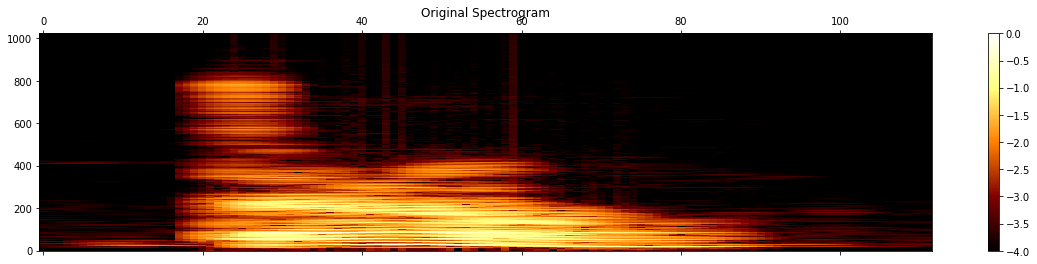

In [259]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(spec1.detach().cpu().numpy()), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')


Text(0.5, 1.05, 'Reconstructed Spectrogram')

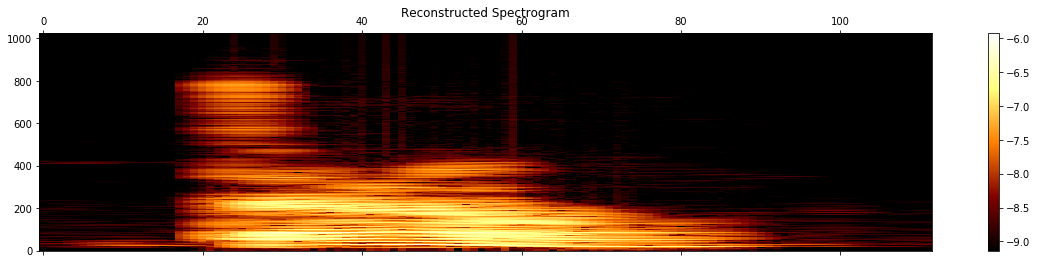

In [260]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(ad_output), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Reconstructed Spectrogram')